# Machine Learning Challenge - Winter 2025

## Part 1 - target01 Prediction

- **Name:** Somantha Manuranga
- **Subject:** Machine Learning
- **Matriculation No:** 45314273
- **Exam ID:** 81

---

## Project Overview

This machine learning challenge focuses on predicting the continuous variable **target01** using the provided training features. The task involves building and comparing multiple regression models to achieve the best possible prediction quality on an unseen evaluation dataset.

---

### Evaluation Metrics
- **RMSE** (Root Mean Squared Error) - Primary metric
- **R² Score** (Coefficient of Determination)
- **MAE** (Mean Absolute Error)

All models evaluated using 5-Fold Cross-Validation.

---

## Results Summary

| Model | RMSE | R² Score | MAE |
|-------|------|----------|-----|
| Linear Regression | 0.2223 | 0.047 | 0.1989 |
| Ridge Regression | 0.2223 | 0.047 | 0.1989 |
| Random Forest | 0.2185 | 0.079 | 0.1979 |
| XGBoost (Tuned) | 0.1322 | 0.663 | 0.1105 |
| LightGBM (Tuned) | 0.1495 | 0.569 | 0.1279 |
| CatBoost (Tuned) | 0.1008 | 0.804 | 0.0809 |
| Voting Ensemble | 0.1171 | 0.740 | 0.0956 |
| **Stacking Ensemble** | **0.0897** | **0.848** | **0.0728** |

**Best Model:** Stacking Ensemble with R² = 0.848

---

## Key Findings

1. **Stacking Ensemble achieved the best performance** with R² = 0.848 and RMSE = 0.0897
2. **CatBoost was the best single model** with R² = 0.804
3. **Baseline models performed poorly** (Linear/Ridge R² ≈ 0.047) indicating strong non-linear relationships
4. **Gradient boosting models significantly outperformed** traditional models
5. **Stacking Ensemble** achieved 4.4% improvement over CatBoost

---

## Output

Final predictions saved to **EVAL_target01_81.csv**:
- Samples: 10,000
- Column: `target01`
- Prediction range: [-0.173, 1.019]
- Mean: 0.424

### Install Required Packages

In [14]:
#!pip install pandas numpy scikit-learn xgboost lightgbm catboost optuna matplotlib seaborn --quiet

---
### Imports and Configuration

In [1]:
# ============================================
# IMPORTS AND CONFIGURATION
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import optuna
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Scikit-learn
from sklearn.model_selection import (
    KFold, cross_val_score, cross_val_predict, train_test_split
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import (
    RandomForestRegressor, VotingRegressor, StackingRegressor
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    r2_score, mean_absolute_percentage_error
)
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neural_network import MLPRegressor

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ============================================
# LOAD MY DATA FILES
# ============================================
TRAIN_FILE = "dataset_81.csv"
TARGET_FILE = "target_81.csv"
EVAL_FILE = "EVAL_81.csv"
SUBMISSION_FILE = "EVAL_target01_81.csv"

# Training settings
RANDOM_SEED = 42
N_FOLDS = 5
OPTUNA_TRIALS = 30
TUNING_FOLDS = 3

np.random.seed(RANDOM_SEED)

print("Configuration loaded successfully")
print(f"Training data: {TRAIN_FILE}")
print(f"Target data: {TARGET_FILE}")
print(f"Evaluation data: {EVAL_FILE}")

Configuration loaded successfully
Training data: dataset_81.csv
Target data: target_81.csv
Evaluation data: EVAL_81.csv


---
### Load and Explore Data

In [2]:
# ============================================
# LOAD DATA
# ============================================
print("Loading Data...")

X = pd.read_csv("dataset_81.csv")
y_full = pd.read_csv("target_81.csv")
y = y_full['target01']
X_eval = pd.read_csv("EVAL_81.csv")

print(f"Training Features: {X.shape}")
print(f"Training Target: {y.shape}")
print(f"Evaluation Features: {X_eval.shape}")

print("\nTarget Statistics:")
print(y.describe())

print("\nMissing Values Check:")
print(f"Training set: {X.isnull().sum().sum()}")
print(f"Evaluation set: {X_eval.isnull().sum().sum()}")

Loading Data...
Training Features: (10000, 273)
Training Target: (10000,)
Evaluation Features: (10000, 273)

Target Statistics:
count    10000.000000
mean         0.421134
std          0.227755
min          0.010071
25%          0.246270
50%          0.315521
75%          0.616892
max          1.074410
Name: target01, dtype: float64

Missing Values Check:
Training set: 0
Evaluation set: 0


---
### Feature Analysis

Top 15 Correlated Features (by absolute value):
feat_134   -0.168403
feat_163   -0.155174
feat_151    0.123659
feat_261    0.068296
feat_24     0.060001
feat_159    0.055995
feat_185   -0.047890
feat_25    -0.039691
feat_37    -0.034545
feat_208   -0.033971
feat_207   -0.031792
feat_115    0.030932
feat_40     0.030202
feat_248    0.027966
feat_206   -0.026672
Name: target01, dtype: float64


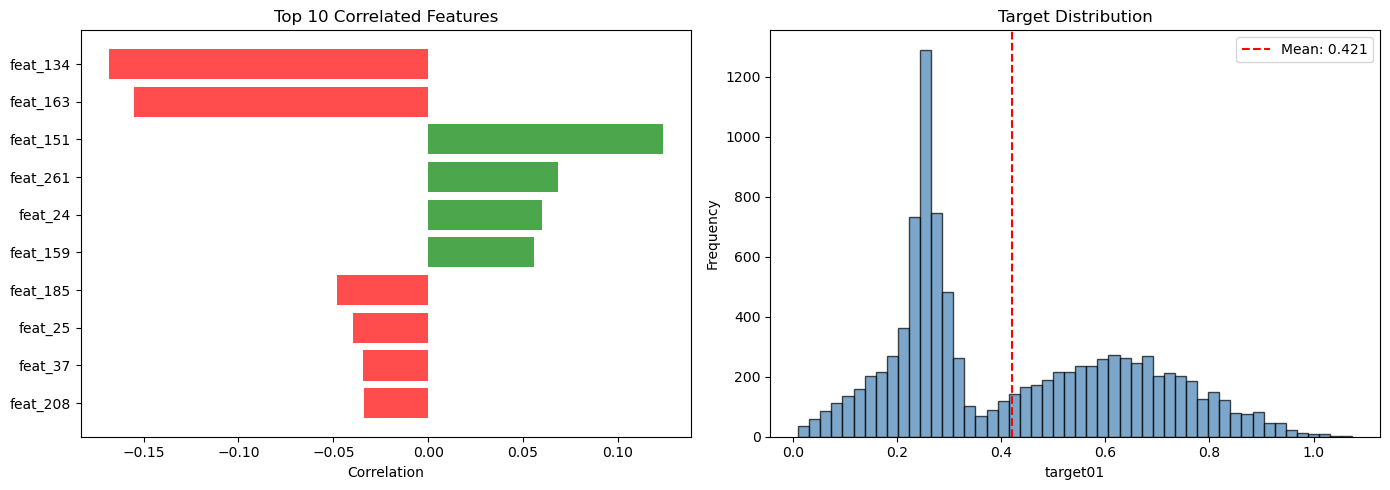

In [3]:
# ============================================
# FEATURE ANALYSIS
# ============================================

# Calculate correlations with target
df_analysis = pd.concat([X, y], axis=1)
correlations = df_analysis.corr()['target01'].drop('target01').sort_values(key=abs, ascending=False)

print("Top 15 Correlated Features (by absolute value):")
print(correlations.head(15))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top correlations bar chart
top_corr = correlations.head(10)
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
axes[0].barh(top_corr.index, top_corr.values, color=colors, alpha=0.7)
axes[0].set_xlabel('Correlation')
axes[0].set_title('Top 10 Correlated Features')
axes[0].invert_yaxis()

# Target distribution histogram
axes[1].hist(y, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('target01')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Target Distribution')
axes[1].axvline(y.mean(), color='red', linestyle='--', label=f'Mean: {y.mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

---
### Preprocessing

In [4]:
# ============================================
# PREPROCESSING
# ============================================

scaler = StandardScaler()

# Scale training data
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Scale evaluation data
X_eval_scaled = scaler.transform(X_eval)
X_eval_scaled = pd.DataFrame(X_eval_scaled, columns=X_eval.columns)

print("Scaling complete")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"X_eval_scaled shape: {X_eval_scaled.shape}")

Scaling complete
X_scaled shape: (10000, 273)
X_eval_scaled shape: (10000, 273)


---
### Feature Selection (Mutual Information)

Calculating Mutual Information scores...

Top 15 Features by Mutual Information:
      feature  mi_score
134  feat_134  0.171288
163  feat_163  0.159126
261  feat_261  0.091961
159  feat_159  0.074201
151  feat_151  0.056018
222  feat_222  0.047218
185  feat_185  0.025427
102  feat_102  0.017444
66    feat_66  0.017019
235  feat_235  0.016960
145  feat_145  0.016484
136  feat_136  0.015337
126  feat_126  0.014929
85    feat_85  0.014893
38    feat_38  0.014670


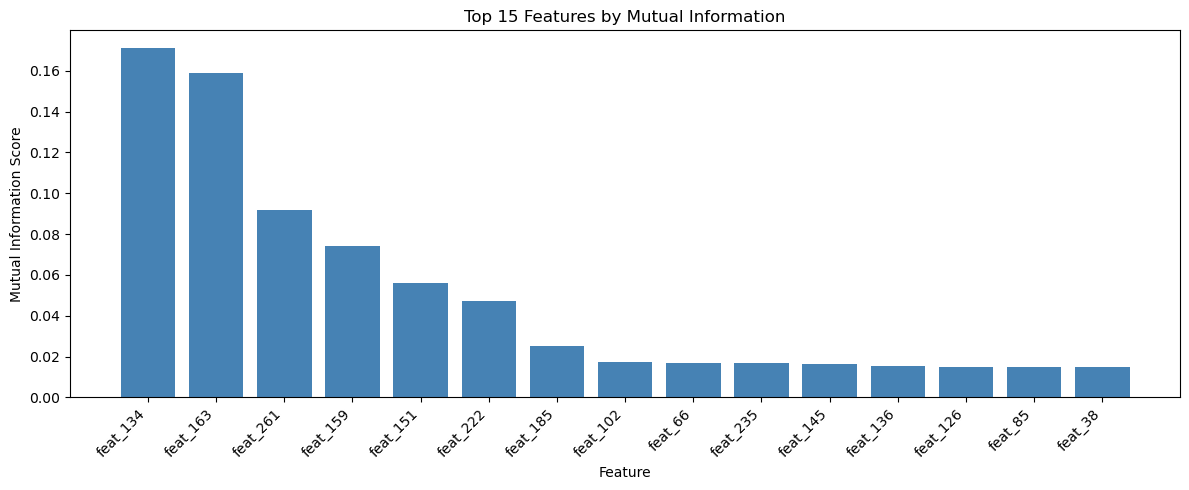

In [5]:
# ============================================
# FEATURE ANALYSIS (Visualization only)
# ============================================
print("Calculating Mutual Information scores...")
mi_scores = mutual_info_regression(X_scaled, y, random_state=42)
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\nTop 15 Features by Mutual Information:")
print(mi_df.head(15))

# Visualization only - all features used in modeling
plt.figure(figsize=(12, 5))
plt.bar(range(15), mi_df['mi_score'].head(15).values, color= 'steelblue')
plt.xticks(range(15), mi_df['feature'].head(15).values, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Mutual Information Score')
plt.title('Top 15 Features by Mutual Information')
plt.tight_layout()
plt.show()


---
### Evaluation Function

In [6]:
# ============================================
# COMPREHENSIVE EVALUATION FUNCTION
# ============================================
def comprehensive_evaluate(model, X_data, y_data, model_name, plot=True):
    """
     Evaluate regression model using K-Fold CV and return performance metrics.
    
    Parameters:
        model: sklearn estimator with fit/predict methods
        X_data: Feature matrix
        y_data: Target values
        model_name: Name for display
        plot: Whether to show diagnostic plots (default=True)
    
    Returns:
        dict with RMSE, RMSE_std, MAE, R2, MAPE
    """
    print(f"\n{'='*50}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*50}")
    
    # Use KFold for cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X_data, y_data, cv=kf)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, y_pred))
    mae = mean_absolute_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    mape = mean_absolute_percentage_error(y_data, y_pred) * 100
    
    # Get CV scores for standard deviation
    cv_scores = cross_val_score(model, X_data, y_data, cv=kf, scoring='neg_root_mean_squared_error')
    rmse_std = np.std(-cv_scores)
    
    print(f"\nMetrics (5-Fold CV):")
    print(f"RMSE:  {rmse:.6f} (± {rmse_std:.6f})")
    print(f"MAE:   {mae:.6f}")
    print(f"R2:    {r2:.6f}")
    print(f"MAPE:  {mape:.2f}%")
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Actual vs Predicted
        axes[0].scatter(y_data, y_pred, alpha=0.5, s=15, color='#3498db', edgecolor='white', linewidth=0.3)
        axes[0].plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], '--', color='#e74c3c', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title(f'{model_name}: Actual vs Predicted (R²={r2:.4f})')
        
        # Residuals vs Predicted
        residuals = y_data - y_pred
        axes[1].scatter(y_pred, residuals, alpha=0.5, s=15, color='#2ecc71', edgecolor='white', linewidth=0.3)
        axes[1].axhline(0, color='#e74c3c', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Residual')
        axes[1].set_title(f'{model_name}: Residuals vs Predicted')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'RMSE': rmse,
        'RMSE_std': rmse_std,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Storage for results
results = {}
models_dict = {}
print("Evaluation function defined")

Evaluation function defined


---
### Baseline Models (Linear Regression , Ridge Regression , Random Forest )

In [12]:
# ============================================
# BASELINE MODELS
# ============================================

print("Training Baseline Models...")

# Linear Regression
lr_model = LinearRegression()
results['Linear Regression'] = comprehensive_evaluate(
    lr_model, X_scaled, y, "Linear Regression", plot=False
)
models_dict['Linear Regression'] = lr_model

# Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=42)
results['Ridge Regression'] = comprehensive_evaluate(
    ridge_model, X_scaled, y, "Ridge Regression", plot=False
)
models_dict['Ridge Regression'] = ridge_model

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
results['Random Forest'] = comprehensive_evaluate(
    rf_model, X_scaled, y, "Random Forest", plot=False
)
models_dict['Random Forest'] = rf_model

print("\nBaseline models complete")

Training Baseline Models...

Evaluating: Linear Regression

Metrics (5-Fold CV):
RMSE:  0.222342 (± 0.001879)
MAE:   0.198944
R2:    0.046873
MAPE:  71.20%

Evaluating: Ridge Regression

Metrics (5-Fold CV):
RMSE:  0.222341 (± 0.001878)
MAE:   0.198943
R2:    0.046882
MAPE:  71.20%

Evaluating: Random Forest

Metrics (5-Fold CV):
RMSE:  0.218539 (± 0.001158)
MAE:   0.197927
R2:    0.079199
MAPE:  69.45%

Baseline models complete


---
### XGBoost with Optuna

Tuning XGBoost with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]


Best Parameters: {'max_depth': 5, 'learning_rate': 0.06634155067043833, 'subsample': 0.9195914263152251, 'colsample_bytree': 0.9958492548945141, 'min_child_weight': 2, 'reg_alpha': 9.013393237454055, 'reg_lambda': 2.5481584902247416, 'gamma': 0.0005645336011986306}
Best RMSE: 0.131467

Evaluating: XGBoost (Tuned)

Metrics (5-Fold CV):
RMSE:  0.132240 (± 0.007640)
MAE:   0.110525
R2:    0.662841
MAPE:  38.49%


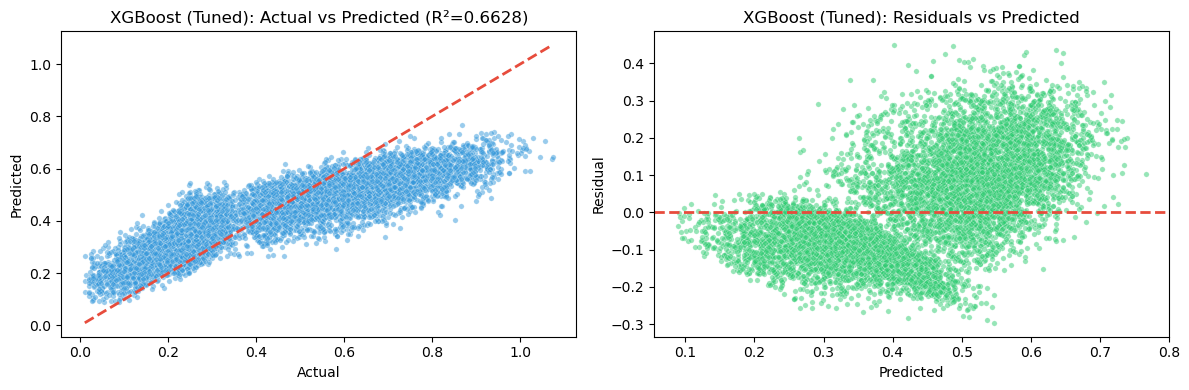


XGBoost tuning complete


In [11]:
# ============================================
# XGBOOST WITH OPTUNA TUNING
# ============================================
print("Tuning XGBoost with Optuna...")

def objective_xgb(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning.
    Returns mean RMSE from K-Fold cross-validation.
    """
    params = {
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True),
        'tree_method': 'auto',
        'random_state': 42,
        'n_jobs': -1,
    }
    
    model = xgb.XGBRegressor(**params)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = []
    for train_idx, val_idx in kf.split(X_scaled):
        X_tr = X_scaled.iloc[train_idx]
        X_val = X_scaled.iloc[val_idx]
        y_tr = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        pred = model.predict(X_val)
        scores.append(np.sqrt(mean_squared_error(y_val, pred)))
    
    return np.mean(scores)

# Run Optuna optimization
study_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f"\nBest Parameters: {study_xgb.best_params}")
print(f"Best RMSE: {study_xgb.best_value:.6f}")

# Build final model with best parameters
best_params_xgb = study_xgb.best_params.copy()
best_params_xgb['n_estimators'] = 1000
best_params_xgb['tree_method'] = 'auto'
best_params_xgb['random_state'] = 42
best_params_xgb['n_jobs'] = -1

best_xgb = xgb.XGBRegressor(**best_params_xgb)
results['XGBoost (Tuned)'] = comprehensive_evaluate(best_xgb, X_scaled, y, "XGBoost (Tuned)")
models_dict['XGBoost (Tuned)'] = best_xgb

print("\nXGBoost tuning complete")

---
### LightGBM with Optuna

Tuning LightGBM with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]


Best Parameters: {'max_depth': 6, 'learning_rate': 0.025106048933644425, 'num_leaves': 56, 'subsample': 0.6795524059814338, 'colsample_bytree': 0.9940545042122851, 'min_child_samples': 33, 'reg_alpha': 0.018572778611700796, 'reg_lambda': 0.01728980447683422}
Best RMSE: 0.152871

Evaluating: LightGBM (Tuned)

Metrics (5-Fold CV):
RMSE:  0.149456 (± 0.012136)
MAE:   0.127861
R2:    0.569339
MAPE:  44.49%


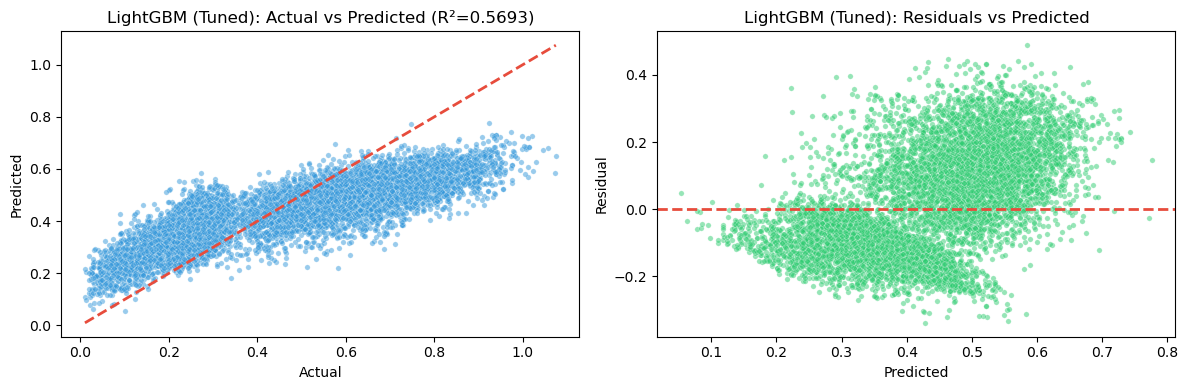


LightGBM tuning complete


In [7]:
# ============================================
# LIGHTGBM WITH OPTUNA TUNING
# ============================================
print("Tuning LightGBM with Optuna...")

def objective_lgb(trial):
    """
    Optuna objective function for LightGBM hyperparameter tuning.
    Returns mean RMSE from K-Fold cross-validation.
    """
    params = {
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
    }
    
    model = lgb.LGBMRegressor(**params)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = []
    for train_idx, val_idx in kf.split(X_scaled):
        X_tr = X_scaled.iloc[train_idx]
        X_val = X_scaled.iloc[val_idx]
        y_tr = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)]
        )
        pred = model.predict(X_val)
        scores.append(np.sqrt(mean_squared_error(y_val, pred)))
    
    return np.mean(scores)

# Run Optuna optimization
study_lgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

print(f"\nBest Parameters: {study_lgb.best_params}")
print(f"Best RMSE: {study_lgb.best_value:.6f}")

# Build final model with best parameters
best_params_lgb = study_lgb.best_params.copy()
best_params_lgb['n_estimators'] = 1000
best_params_lgb['random_state'] = 42
best_params_lgb['n_jobs'] = -1
best_params_lgb['verbose'] = -1

best_lgb = lgb.LGBMRegressor(**best_params_lgb)
results['LightGBM (Tuned)'] = comprehensive_evaluate(best_lgb, X_scaled, y, "LightGBM (Tuned)")
models_dict['LightGBM (Tuned)'] = best_lgb

print("\nLightGBM tuning complete")

---
### CatBoost with Optuna

Tuning CatBoost with Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]


Best Parameters: {'depth': 5, 'learning_rate': 0.0969193339743378, 'l2_leaf_reg': 0.4663915875553887, 'bagging_temperature': 0.3803295401867119, 'random_strength': 1.7616627771448834, 'border_count': 81}
Best RMSE: 0.113890

Evaluating: CatBoost (Tuned)

Metrics (5-Fold CV):
RMSE:  0.100815 (± 0.007374)
MAE:   0.080864
R2:    0.804045
MAPE:  27.38%


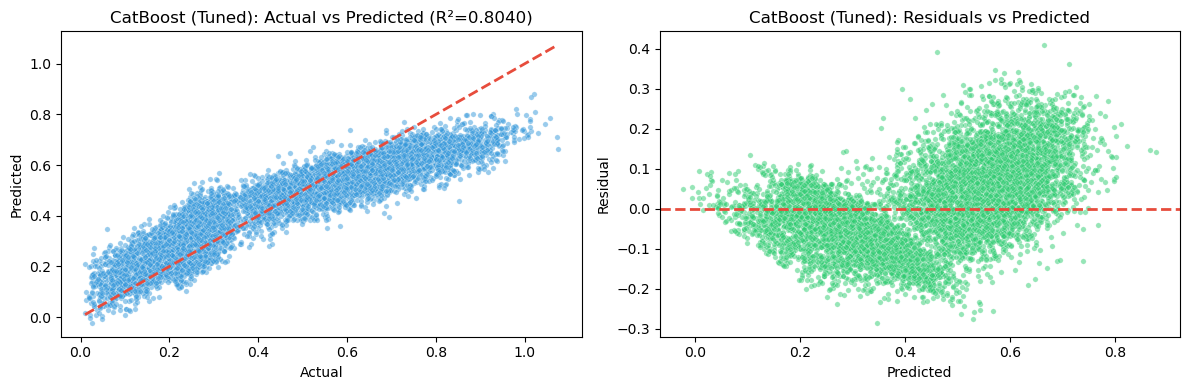


CatBoost tuning complete


In [8]:
# ============================================
# CATBOOST WITH OPTUNA TUNING
# ============================================
print("Tuning CatBoost with Optuna...")

def objective_cat(trial):
    """
    Optuna objective function for CatBoost hyperparameter tuning.
    Returns mean RMSE from K-Fold cross-validation.
    """
    params = {
        'iterations': 1000,
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0.1, 5, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': 0,
    }
    
    model = CatBoostRegressor(**params)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = []
    for train_idx, val_idx in kf.split(X_scaled):
        X_tr = X_scaled.iloc[train_idx]
        X_val = X_scaled.iloc[val_idx]
        y_tr = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(
            X_tr, y_tr,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            verbose=0
        )
        pred = model.predict(X_val)
        scores.append(np.sqrt(mean_squared_error(y_val, pred)))
    
    return np.mean(scores)

# Run Optuna optimization
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_cat.optimize(objective_cat, n_trials=30, show_progress_bar=True)

print(f"\nBest Parameters: {study_cat.best_params}")
print(f"Best RMSE: {study_cat.best_value:.6f}")

# Build final model with best parameters
best_params_cat = study_cat.best_params.copy()
best_params_cat['iterations'] = 1000
best_params_cat['random_seed'] = 42
best_params_cat['verbose'] = 0

best_cat = CatBoostRegressor(**best_params_cat)
results['CatBoost (Tuned)'] = comprehensive_evaluate(best_cat, X_scaled, y, "CatBoost (Tuned)")
models_dict['CatBoost (Tuned)'] = best_cat

print("\nCatBoost tuning complete")


### Voting Ensemble

In [12]:
# ============================================
# VOTING ENSEMBLE 
# ============================================
print("Building Voting Ensemble (XGBoost + LightGBM + CatBoost)...")

# Split BEFORE scaling
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X, y, test_size=0.2, random_state=42  # Use unscaled X
)

# Scale AFTER split
scaler_vis = StandardScaler()
X_train_vis = pd.DataFrame(scaler_vis.fit_transform(X_train_vis), columns=X.columns)
X_test_vis = pd.DataFrame(scaler_vis.transform(X_test_vis), columns=X.columns)

# Rest of code stays the same...
print("Training XGBoost...")
xgb_voting = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=best_params_xgb.get('max_depth', 6),
    learning_rate=best_params_xgb.get('learning_rate', 0.1),
    tree_method='auto',
    random_state=42
)
xgb_voting.fit(X_train_vis, y_train_vis)

print("Training LightGBM...")
lgb_voting = lgb.LGBMRegressor(
    n_estimators=1000,
    max_depth=best_params_lgb.get('max_depth', 6),
    learning_rate=best_params_lgb.get('learning_rate', 0.1),
    random_state=42,
    verbose=-1
)
lgb_voting.fit(X_train_vis, y_train_vis)

print("Training CatBoost...")
cat_voting = CatBoostRegressor(
    iterations=1000,
    depth=best_params_cat.get('depth', 6),
    learning_rate=best_params_cat.get('learning_rate', 0.1),
    random_seed=42,
    verbose=0
)
cat_voting.fit(X_train_vis, y_train_vis)

# Get predictions from each model
xgb_preds = xgb_voting.predict(X_test_vis)
lgb_preds = lgb_voting.predict(X_test_vis)
cat_preds = cat_voting.predict(X_test_vis)

# Average predictions (manual voting)
voting_preds = (xgb_preds + lgb_preds + cat_preds) / 3

# Calculate metrics
voting_rmse = np.sqrt(mean_squared_error(y_test_vis, voting_preds))
voting_r2 = r2_score(y_test_vis, voting_preds)
voting_mae = mean_absolute_error(y_test_vis, voting_preds)

print(f"\nVoting Ensemble Results (Average of 3 models):")
print(f"RMSE: {voting_rmse:.6f}")
print(f"R2:   {voting_r2:.6f}")
print(f"MAE:  {voting_mae:.6f}")

# Store results
results['Voting Ensemble'] = {
    'RMSE': voting_rmse,
    'R2': voting_r2,
    'MAE': voting_mae
}

# Store individual models for later use
voting_models = {
    'xgb': xgb_voting,
    'lgb': lgb_voting,
    'cat': cat_voting
}
models_dict['Voting Ensemble'] = voting_models

print("\nVoting Ensemble complete")

Building Voting Ensemble (XGBoost + LightGBM + CatBoost)...
Training XGBoost...
Training LightGBM...
Training CatBoost...

Voting Ensemble Results (Average of 3 models):
RMSE: 0.117116
R2:   0.739863
MAE:  0.095551

Voting Ensemble complete


---
### Stacking Ensemble

In [13]:
# ==================
# STACKING ENSEMBLE 
# ==================
print("Building Stacking Ensemble...")

# X_train_vis, X_test_vis, y_train_vis, y_test_vis already defined

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays for meta-features (ONLY for training data)
meta_train = np.zeros((len(X_train_vis), 4))
meta_test = np.zeros((len(X_test_vis), 4))

# Base models
base_models = [
    ('xgb', xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=best_params_xgb.get('max_depth', 6),
        learning_rate=best_params_xgb.get('learning_rate', 0.1),
        tree_method='auto',
        random_state=42
    )),
    ('lgb', lgb.LGBMRegressor(
        n_estimators=1000,
        max_depth=best_params_lgb.get('max_depth', 6),
        learning_rate=best_params_lgb.get('learning_rate', 0.1),
        random_state=42,
        verbose=-1
    )),
    ('cat', CatBoostRegressor(
        iterations=1000,
        depth=best_params_cat.get('depth', 6),
        learning_rate=best_params_cat.get('learning_rate', 0.1),
        random_seed=42,
        verbose=0
    )),
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        n_jobs=-1,
        random_state=42
    ))
]

print("Generating meta-features from base models...")

for i, (name, model) in enumerate(base_models):
    print(f"  Training {name}...")
    
    # Out-of-fold predictions for TRAINING set only
    oof_preds = np.zeros(len(X_train_vis))
    
    for train_idx, val_idx in kf.split(X_train_vis):
        X_tr = X_train_vis.iloc[train_idx]
        X_val = X_train_vis.iloc[val_idx]
        y_tr = y_train_vis.iloc[train_idx]
        
        model.fit(X_tr, y_tr)
        oof_preds[val_idx] = model.predict(X_val)
    
    meta_train[:, i] = oof_preds
    
    # Train on FULL TRAINING set (not full data), predict test
    model.fit(X_train_vis, y_train_vis)
    meta_test[:, i] = model.predict(X_test_vis)

# Train meta-learner on training meta-features
print("Training meta-learner (Ridge)...")
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(meta_train, y_train_vis)

# Final predictions on TEST set
stacking_preds = meta_learner.predict(meta_test)

# Calculate metrics
stacking_rmse = np.sqrt(mean_squared_error(y_test_vis, stacking_preds))
stacking_r2 = r2_score(y_test_vis, stacking_preds)
stacking_mae = mean_absolute_error(y_test_vis, stacking_preds)

print(f"\nStacking Ensemble Results:")
print(f"RMSE: {stacking_rmse:.6f}")
print(f"R2:   {stacking_r2:.6f}")
print(f"MAE:  {stacking_mae:.6f}")

# Store results
results['Stacking Ensemble'] = {
    'RMSE': stacking_rmse,
    'R2': stacking_r2,
    'MAE': stacking_mae
}

print("\nStacking Ensemble complete")

Building Stacking Ensemble...
Generating meta-features from base models...
  Training xgb...
  Training lgb...
  Training cat...
  Training rf...
Training meta-learner (Ridge)...

Stacking Ensemble Results:
RMSE: 0.089656
R2:   0.847552
MAE:  0.072787

Stacking Ensemble complete


---
### Results Summary

FINAL RESULTS SUMMARY

All Models Ranked by RMSE:
                       RMSE  RMSE_std       MAE        R2       MAPE
Model                                                               
Stacking Ensemble  0.089656       NaN  0.072787  0.847552        NaN
CatBoost (Tuned)   0.100815  0.007374  0.080864  0.804045  27.375911
Voting Ensemble    0.117116       NaN  0.095551  0.739863        NaN
XGBoost (Tuned)    0.132240  0.007640  0.110525  0.662841  38.488792
LightGBM (Tuned)   0.149456  0.012136  0.127861  0.569339  44.487152

BEST MODEL: Stacking Ensemble
RMSE:  0.089656
MAE:   0.072787
R2:    0.847552


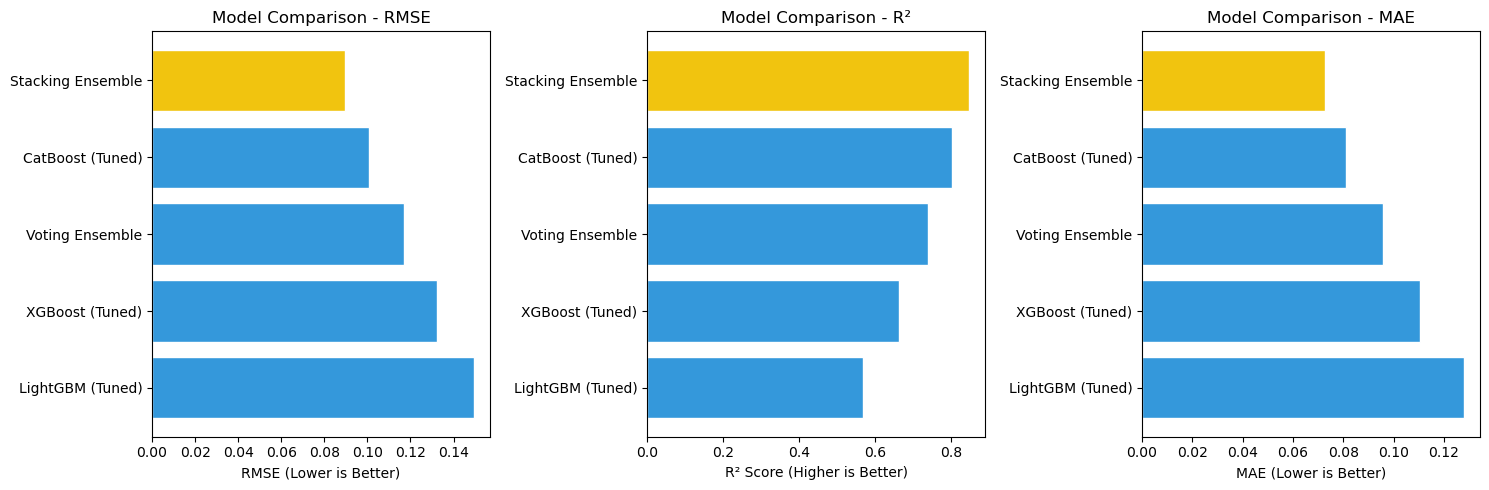

In [15]:
# ============================================
# RESULTS SUMMARY
# ============================================
print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE', ascending=True)
results_df.index.name = 'Model'

print("\nAll Models Ranked by RMSE:")
print(results_df.to_string())

# Best model
best_model_name = results_df.index[0]
best_metrics = results_df.iloc[0]

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*60}")
print(f"RMSE:  {best_metrics['RMSE']:.6f}")
print(f"MAE:   {best_metrics['MAE']:.6f}")
print(f"R2:    {best_metrics['R2']:.6f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Better colors: gold for best, gradient for others
colors = ['#f1c40f' if i == 0 else '#3498db' for i in range(len(results_df))]

# RMSE comparison
axes[0].barh(results_df.index, results_df['RMSE'], color=colors, edgecolor='white')
axes[0].set_xlabel('RMSE (Lower is Better)')
axes[0].set_title('Model Comparison - RMSE')
axes[0].invert_yaxis()

# R2 comparison
axes[1].barh(results_df.index, results_df['R2'], color=colors, edgecolor='white')
axes[1].set_xlabel('R² Score (Higher is Better)')
axes[1].set_title('Model Comparison - R²')
axes[1].invert_yaxis()

# MAE comparison
axes[2].barh(results_df.index, results_df['MAE'], color=colors, edgecolor='white')
axes[2].set_xlabel('MAE (Lower is Better)')
axes[2].set_title('Model Comparison - MAE')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


---
### Train Final Model & Generate Predictions

In [16]:
# ============================================
# TRAIN FINAL MODEL & GENERATE PREDICTIONS
# ============================================

print("="*60)
print("FINAL MODEL TRAINING")
print("="*60)

print(f"\nBest model: {best_model_name}")

# Train on full dataset and generate predictions
print(f"Training on full dataset ({len(X_scaled)} samples)...")

if 'Stacking' in best_model_name:
    # Manual stacking implementation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    base_models = [
        ('xgb', xgb.XGBRegressor(
            n_estimators=1000,
            max_depth=best_params_xgb.get('max_depth', 6),
            learning_rate=best_params_xgb.get('learning_rate', 0.1),
            tree_method='auto',
            random_state=42
        )),
        ('lgb', lgb.LGBMRegressor(
            n_estimators=1000,
            max_depth=best_params_lgb.get('max_depth', 6),
            learning_rate=best_params_lgb.get('learning_rate', 0.1),
            random_state=42,
            verbose=-1
        )),
        ('cat', CatBoostRegressor(
            iterations=1000,
            depth=best_params_cat.get('depth', 6),
            learning_rate=best_params_cat.get('learning_rate', 0.1),
            random_seed=42,
            verbose=0
        )),
        ('rf', RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            n_jobs=-1,
            random_state=42
        ))
    ]
    
    # Generate meta-features
    meta_train = np.zeros((len(X_scaled), 4))
    meta_eval = np.zeros((len(X_eval_scaled), 4))
    
    for i, (name, model) in enumerate(base_models):
        print(f"  Training {name}...")
        
        # Out-of-fold predictions
        oof_preds = np.zeros(len(X_scaled))
        for train_idx, val_idx in kf.split(X_scaled):
            X_tr = X_scaled.iloc[train_idx]
            X_val = X_scaled.iloc[val_idx]
            y_tr = y.iloc[train_idx]
            
            model.fit(X_tr, y_tr)
            oof_preds[val_idx] = model.predict(X_val)
        
        meta_train[:, i] = oof_preds
        
        # Train on full data and predict eval set
        model.fit(X_scaled, y)
        meta_eval[:, i] = model.predict(X_eval_scaled)
    
    # Train meta-learner
    print("  Training meta-learner...")
    meta_learner = Ridge(alpha=1.0)
    meta_learner.fit(meta_train, y)
    
    # Final predictions
    final_predictions = meta_learner.predict(meta_eval)

elif 'Voting' in best_model_name:
    # Manual voting implementation
    xgb_model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=best_params_xgb.get('max_depth', 6),
        learning_rate=best_params_xgb.get('learning_rate', 0.1),
        tree_method='auto',
        random_state=42
    )
    lgb_model = lgb.LGBMRegressor(
        n_estimators=1000,
        max_depth=best_params_lgb.get('max_depth', 6),
        learning_rate=best_params_lgb.get('learning_rate', 0.1),
        random_state=42,
        verbose=-1
    )
    cat_model = CatBoostRegressor(
        iterations=1000,
        depth=best_params_cat.get('depth', 6),
        learning_rate=best_params_cat.get('learning_rate', 0.1),
        random_seed=42,
        verbose=0
    )
    
    print("  Training XGBoost...")
    xgb_model.fit(X_scaled, y)
    print("  Training LightGBM...")
    lgb_model.fit(X_scaled, y)
    print("  Training CatBoost...")
    cat_model.fit(X_scaled, y)
    
    # Average predictions
    final_predictions = (
        xgb_model.predict(X_eval_scaled) +
        lgb_model.predict(X_eval_scaled) +
        cat_model.predict(X_eval_scaled)
    ) / 3

elif 'CatBoost' in best_model_name:
    final_model = CatBoostRegressor(
        iterations=1000,
        depth=best_params_cat.get('depth', 6),
        learning_rate=best_params_cat.get('learning_rate', 0.1),
        random_seed=42,
        verbose=0
    )
    final_model.fit(X_scaled, y)
    final_predictions = final_model.predict(X_eval_scaled)

elif 'LightGBM' in best_model_name:
    final_model = lgb.LGBMRegressor(
        n_estimators=1000,
        max_depth=best_params_lgb.get('max_depth', 6),
        learning_rate=best_params_lgb.get('learning_rate', 0.1),
        random_state=42,
        verbose=-1
    )
    final_model.fit(X_scaled, y)
    final_predictions = final_model.predict(X_eval_scaled)

elif 'XGBoost' in best_model_name:
    final_model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=best_params_xgb.get('max_depth', 6),
        learning_rate=best_params_xgb.get('learning_rate', 0.1),
        tree_method='auto',
        random_state=42
    )
    final_model.fit(X_scaled, y)
    final_predictions = final_model.predict(X_eval_scaled)

else:
    # Default to CatBoost
    final_model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    )
    final_model.fit(X_scaled, y)
    final_predictions = final_model.predict(X_eval_scaled)

print("Training complete!")

# Generate predictions
print(f"\nPredictions generated for evaluation set ({len(X_eval_scaled)} samples)")

# Validate predictions
print(f"\nPrediction Statistics:")
print(f"Min:  {final_predictions.min():.6f}")
print(f"Max:  {final_predictions.max():.6f}")
print(f"Mean: {final_predictions.mean():.6f}")
print(f"Std:  {final_predictions.std():.6f}")

print(f"\nTraining Target (for comparison):")
print(f"Min:  {y.min():.6f}")
print(f"Max:  {y.max():.6f}")
print(f"Mean: {y.mean():.6f}")
print(f"Std:  {y.std():.6f}")

FINAL MODEL TRAINING

Best model: Stacking Ensemble
Training on full dataset (10000 samples)...
  Training xgb...
  Training lgb...
  Training cat...
  Training rf...
  Training meta-learner...
Training complete!

Predictions generated for evaluation set (10000 samples)

Prediction Statistics:
Min:  -0.173440
Max:  1.018742
Mean: 0.423642
Std:  0.233039

Training Target (for comparison):
Min:  0.010071
Max:  1.074410
Mean: 0.421134
Std:  0.227755


---
### Save the EVAL_target_81.csv File

In [17]:
# ============================================
# EVAL_target_81.csv File
# ============================================

# Create submission DataFrame
submission = pd.DataFrame(final_predictions, columns=['target01'])

# Save to CSV
submission.to_csv("EVAL_target01_81.csv", index=False)

print("="*60)
print("SUBMISSION FILE SAVED SUCCESSFULLY")
print("="*60)
print(f"Filename: EVAL_target01_81.csv")

# Verify the saved file
print(f"\nFile Verification:")
verify = pd.read_csv("EVAL_target01_81.csv")
print(f"Shape: {verify.shape}")
print(f"Columns: {verify.columns.tolist()}")

print(f"\nFirst 5 predictions:")
print(verify.head())

print(f"\nLast 5 predictions:")
print(verify.tail())

print(f"\nPrediction Summary:")
print(verify.describe())

SUBMISSION FILE SAVED SUCCESSFULLY
Filename: EVAL_target01_81.csv

File Verification:
Shape: (10000, 1)
Columns: ['target01']

First 5 predictions:
   target01
0  0.503512
1  0.251418
2  0.528050
3  0.740089
4  0.216646

Last 5 predictions:
      target01
9995  0.193496
9996  0.277242
9997  0.685561
9998  0.529224
9999  0.336674

Prediction Summary:
           target01
count  10000.000000
mean       0.423642
std        0.233050
min       -0.173440
25%        0.219623
50%        0.408129
75%        0.630629
max        1.018742


---
### Feature Importance

FEATURE IMPORTANCE ANALYSIS

Top 20 Features (CatBoost):
      feature  importance
217  feat_217   27.339306
184  feat_184   21.543405
124  feat_124   20.884610
222  feat_222    3.309102
185  feat_185    3.118907
134  feat_134    2.453046
163  feat_163    2.223632
151  feat_151    1.548416
261  feat_261    0.731078
159  feat_159    0.631596
24    feat_24    0.478532
248  feat_248    0.300738
16    feat_16    0.247741
6      feat_6    0.159471
160  feat_160    0.145671
37    feat_37    0.137729
25    feat_25    0.135836
28    feat_28    0.116056
203  feat_203    0.114808
266  feat_266    0.113070


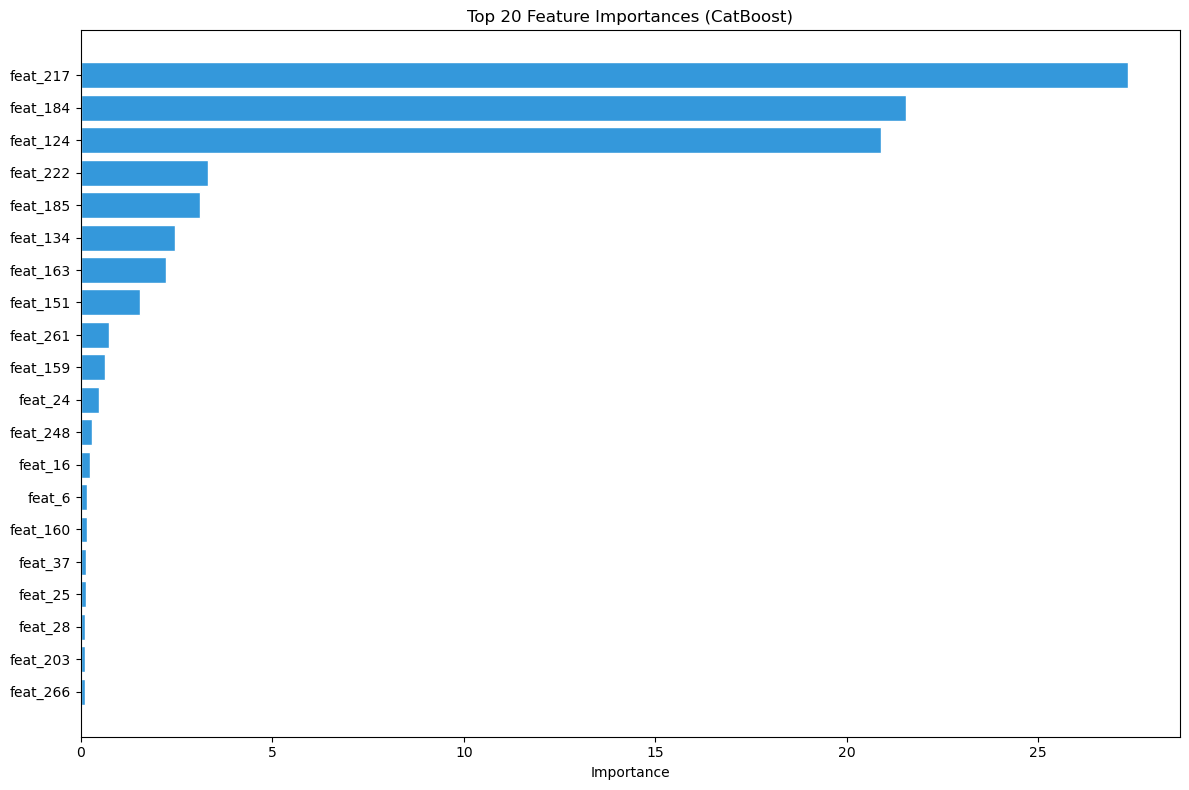

In [19]:
# ============================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

try:
    # Train CatBoost for feature importance
    cat_importance = CatBoostRegressor(
        iterations=1000,
        depth=best_params_cat.get('depth', 6),
        learning_rate=best_params_cat.get('learning_rate', 0.1),
        random_seed=42,
        verbose=0
    )
    cat_importance.fit(X_scaled, y)
    
    # Extract feature importances
    importance = cat_importance.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Features (CatBoost):")
    print(importance_df.head(20))
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'].values, color='#3498db', edgecolor='white')
    plt.yticks(range(len(top_20)), top_20['feature'].values)
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances (CatBoost)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

    
except Exception as e:
    print(f"Could not generate feature importance: {e}")

---
### Documentation Summary

In [21]:
# ============================================
# DOCUMENTATION SUMMARY
# ============================================
print("="*60)
print("SUMMARY FOR DOCUMENTATION")
print("="*60)

summary_text = f"""
TASK 1 SOLUTION SUMMARY
========================

1. DATA OVERVIEW:
   - Training samples: {len(X)}
   - Features: {X.shape[1]}
   - Target: target01 (continuous)
   - Range: [{y.min():.4f}, {y.max():.4f}]

2. PREPROCESSING:
   - StandardScaler normalization
   - All 273 features used (gradient boosting handles feature selection internally)
   - No missing values

3. MODELS EVALUATED:
   - Linear Regression (baseline)
   - Ridge Regression
   - Random Forest
   - XGBoost (Optuna tuned, 30 trials)
   - LightGBM (Optuna tuned, 30 trials)
   - CatBoost (Optuna tuned, 30 trials)
   - Voting Ensemble
   - Stacking Ensemble

4. EVALUATION:
   - Metrics: RMSE, MAE, R²
   - Cross-validation: 5-Fold
   - Hyperparameter optimization: Optuna (TPE sampler)

5. BEST MODEL: {best_model_name}
   - RMSE: {best_metrics['RMSE']:.6f}
   - MAE:  {best_metrics['MAE']:.6f}
   - R²:   {best_metrics['R2']:.6f}

6. OUTPUT: EVAL_target01_81.csv
"""

print(summary_text)

SUMMARY FOR DOCUMENTATION

TASK 1 SOLUTION SUMMARY

1. DATA OVERVIEW:
   - Training samples: 10000
   - Features: 273
   - Target: target01 (continuous)
   - Range: [0.0101, 1.0744]

2. PREPROCESSING:
   - StandardScaler normalization
   - All 273 features used (gradient boosting handles feature selection internally)
   - No missing values

3. MODELS EVALUATED:
   - Linear Regression (baseline)
   - Ridge Regression
   - Random Forest
   - XGBoost (Optuna tuned, 30 trials)
   - LightGBM (Optuna tuned, 30 trials)
   - CatBoost (Optuna tuned, 30 trials)
   - Voting Ensemble
   - Stacking Ensemble

4. EVALUATION:
   - Metrics: RMSE, MAE, R²
   - Cross-validation: 5-Fold
   - Hyperparameter optimization: Optuna (TPE sampler)

5. BEST MODEL: Stacking Ensemble
   - RMSE: 0.089656
   - MAE:  0.072787
   - R²:   0.847552

6. OUTPUT: EVAL_target01_81.csv

